https://www.kaggle.com/kashnitsky/ridge-countvectorizer-baseline

In [58]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import json
from tqdm import tqdm_notebook
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error

from scipy.sparse import csr_matrix, hstack

In [3]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [4]:
PATH_TO_DATA = '../../data/medium/'

In [5]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

In [6]:
def preprocess(path_to_inp_json_file):
    output_list = []
    with open(path_to_inp_json_file, encoding='utf-8') as inp_file:
        for line in tqdm_notebook(inp_file):
            json_data = read_json_line(line)
            content = json_data['content'].replace('\n', ' ').replace('\r', ' ')
            content_no_html_tags = strip_tags(content)
            output_list.append(content_no_html_tags)
    return output_list

In [7]:
%%time
train_raw_content = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 
                                                                  'train.json'),)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Wall time: 5min 10s


In [8]:
%%time
test_raw_content = preprocess(path_to_inp_json_file=os.path.join(PATH_TO_DATA, 
                                                                  'test.json'),)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Wall time: 3min 2s


We'll use a linear model (Ridge) with a very simple feature extractor – CountVectorizer, meaning that we resort to the Bag-of-Words approach. For now, we are leaving only 50k features.

In [9]:
cv = CountVectorizer(max_features=50000)

In [10]:
%%time
X_train = cv.fit_transform(train_raw_content)

Wall time: 1min 33s


In [13]:
%%time
X_test = cv.transform(test_raw_content)

Wall time: 42.7 s


In [73]:
full_raw_content = train_raw_content + test_raw_content

In [74]:
X_full = cv.transform(full_raw_content)

In [14]:
X_train.shape, X_test.shape

((62313, 50000), (34645, 50000))

In [47]:
len(train_len_content), len(test_len_content)

(62313, 34645)

In [16]:
train_target = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_log1p_recommends.csv'), 
                           index_col='id')

In [18]:
train_target.shape

(62313, 1)

In [19]:
y_train = train_target['log_recommends'].values

## Добавим длину статьи

In [44]:
train_len_content = [len(x) for x in train_raw_content]
test_len_content = [len(x) for x in test_raw_content]

In [71]:
idx_split = len(train_len_content)

In [69]:
full_len = train_len_content + test_len_content

In [70]:
%%time
full_len_OHE = pd.get_dummies(pd.Series(full_len))

Wall time: 3.74 s


In [2]:
import pandas as pd
full_len_OHE = pd.get_dummies(pd.Series([1,1,1,2]))

In [3]:
full_len_OHE

,1,2
0,1,0
1,1,0
2,1,0
3,0,1


In [75]:
%%time
X_full_len = hstack([X_full, full_len_OHE]).tocsr()

Wall time: 37.5 s


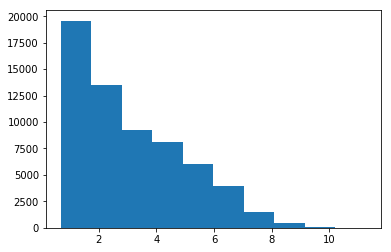

In [21]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(y_train)
plt.show()

Make a 30%-holdout set.

In [22]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part = X_train[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid =  X_train[train_part_size:, :]
y_valid = y_train[train_part_size:]

Now we are ready to fit a linear model.

In [23]:
from sklearn.linear_model import Ridge

In [61]:
ridge = Ridge(random_state=17)

In [25]:
%%time
ridge.fit(X_train_part, y_train_part)

Wall time: 2min 21s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [26]:
ridge_pred = ridge.predict(X_valid)

Let's plot predictions and targets for the holdout set. Recall that these are #recommendations (= #claps) of Medium articles with the np.log1p transformation.

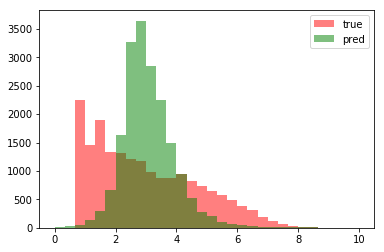

In [27]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

As we can see, the prediction is far from perfect, and we get MAE  ≈  1.3 that corresponds to  ≈  2.7 error in #recommendations.

In [28]:
valid_mae = mean_absolute_error(y_valid, ridge_pred)
valid_mae, np.expm1(valid_mae)

(1.3060947121324362, 2.6917282621565262)

Finally, train the model on the full accessible training set, make predictions for the test set and form a submission file.

In [76]:
%%time
ridge.fit(X_full_len[:idx_split], y_train);

Wall time: 3min 22s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [77]:
%%time
ridge_test_pred = ridge.predict(X_full_len[idx_split:])

Wall time: 773 ms


## Применим хак, он нам говорт, что либо 4.33328 либо 1.67397 среднее значение ответа

In [86]:
ridge_test_pred.mean()

3.1267476225824016

In [83]:
ridge_test_pred_hack = ridge_test_pred + (4.3328 - ridge_test_pred.mean())

In [84]:
ridge_test_pred_hack.mean()

4.3327999999999998

In [31]:
def write_submission_file(prediction, filename,
    path_to_sample=os.path.join(PATH_TO_DATA, 'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [85]:
write_submission_file(prediction=ridge_test_pred_hack, 
                      filename='first_ridge_len_hack.csv')